In [2]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dltk.io import preprocessing
from skimage import filters

import os

In [2]:
# path to .nii file
IMAGE = '/home/sysadm/Downloads/ADNI/002_S_0295/MPR__GradWarp__B1_Correction__N3__Scaled/2006-04-18_08_20_30.0/S13408/ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319113623975_S13408_I45108.nii'

In [3]:
# load in sitk format
sitk_image = sitk.ReadImage(IMAGE)
# transform into a numpy array
img = sitk.GetArrayFromImage(sitk_image)
# check the final shape
img.shape

(166, 256, 256)

### Image Visualization

Now, let's try visualizing the images. Using `matplotlib.pyplot` is a very simple and perfectly valid option, but selecting a certain slice. There are three dimensions that can be used for slicing. In the following cell, slice 70 of the third dimension is shown.

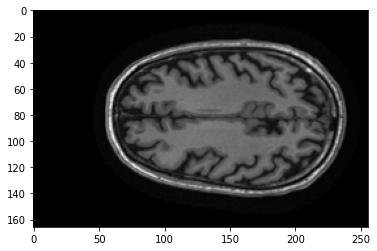

In [4]:
plt.imshow(img[:, :, 70], cmap='gray')
plt.show()

Let´s try appliying otsu´s thresholding,  It should binarize the image. This tecnhique was not used in the final work, this was just a test.


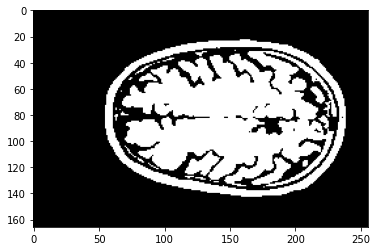

In [5]:
otsu = filters.threshold_otsu(img)
otsu_img = img > otsu
plt.imshow(otsu_img[:, :, 70], cmap='gray')
plt.show()

Now, a very important preprocessing step for the images will be space normalization. For that, the following resample_img method will be used.

In [5]:
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0]):
    ''' This function resamples images to 2-mm isotropic voxels.
      
        Parameters:
            itk_image -- Image in simpleitk format, not a numpy array
            out_spacing -- Space representation of each voxel
            
        Returns: 
            Resulting image in simpleitk format, not a numpy array
    '''
    
    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In the following cell, the method is tried out with the previously loaded image. Also, tried cropping and whitening using `DLTK` methods. Finally, the result is printed, showing the 100th slice of the second axis.

/home/sysadm/.local/lib/python3.8/site-packages/dltk/io/preprocessing.py:87: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad(image[slicer], to_padding, **kwargs)


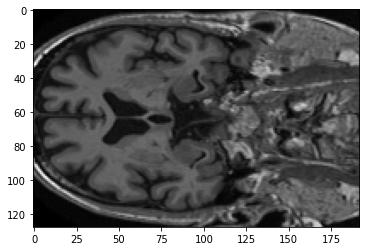

In [7]:
res = resample_img(sitk_image)
res_img = sitk.GetArrayFromImage(sitk_image)
res_img = preprocessing.resize_image_with_crop_or_pad(res_img, img_size=(128, 192, 192), mode='symmetric')
res_img = preprocessing.whitening(res_img)
plt.imshow(res_img[:, 100, :], cmap='gray')
plt.show()

In [6]:
##reference image MNI 305
atlas = sitk.ReadImage('/home/sysadm/Downloads/average305_t1_tal_lin.nii')
atlas = resample_img(atlas)

In [7]:
atlas_img = sitk.GetArrayFromImage(atlas)
atlas_img.shape

(78, 110, 86)

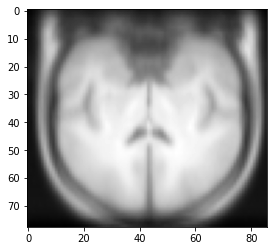

In [14]:
plt.imshow(atlas_img[:, 60, :], cmap='gray')

In [11]:
def registrate(sitk_fixed, sitk_moving, bspline=False):
    ''' Perform image registration using SimpleElastix.
        By default, uses affine transformation.
        
        Parameters:
            sitk_fixed -- Reference atlas (sitk .nii)
            sitk_moving -- Image to be registrated
                           (sitk .nii)
            bspline -- Whether or not to perform non-rigid
                       registration
    '''
    
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk_fixed)
    elastixImageFilter.SetMovingImage(sitk_moving)

    parameterMapVector = sitk.VectorOfParameterMap()
    parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
    if bspline:
        parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    elastixImageFilter.Execute()
    return elastixImageFilter.GetResultImage()

In [12]:

# registered and organized database
REG_DB = '/home/sysadm/Downloads/ADNI_REGISTERED/'
# the images should be divided by its label
REG_DB_SUBFOLDERS = ['AD/', 'MCI/', 'CN/']

In [13]:
##read the csv file
description = pd.read_csv('/home/sysadm/Downloads/ADNI1_Complete_1Yr_1.5T_6_11_2021.csv')
description.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I97341,941_S_1311,MCI,M,70,3,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,NiFTI,6/05/2021
1,I97327,941_S_1311,MCI,M,69,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,6/05/2021
2,I112538,941_S_1311,MCI,M,70,4,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,6/05/2021
3,I75150,941_S_1202,CN,M,78,3,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,6/04/2021
4,I63874,941_S_1202,CN,M,78,1,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,6/04/2021


In [14]:
def register_and_save(filename, path, atlas):
    ''' Process the image name and copy the image to its
        corresponding destination folder.
        
        Parameters:
            filename -- Name of the image file (.nii)
            path -- The path were the image is located
            atlas -- Reference sitk image for registration
    '''
    
    # separate the name of the file by '_'
    splitted_name = filename.strip().split('_')
    # sometimes residual MacOS files appear; ignore them
    if splitted_name[0] == '.': return
    
    # save the image ID
    image_ID = splitted_name[-1][1:-4]
    
    # sometimes empty files appear, just ignore them (macOS issue)
    if image_ID == '': return
    # transform the ID into a int64 numpy variable for indexing
    image_ID = np.int64(image_ID)
    print(image_ID)
        
    #### IMPORTANT #############
    # the following three lines are used to extract the label of the image
    # ADNI data provides a description .csv file that can be indexed using the
    # image ID. If you are not working with ADNI data, then you must be able to 
    # obtain the image label (AD/MCI/NC) in some other way
    # with the ID, index the information we need
    row_index = description.index[description['Image Data ID'] == 'I'+str(image_ID)].tolist()[0]
    # obtain the corresponding row in the dataframe
    row = description.iloc[row_index]
    # get the label
    label = row['Group']
    
    # prepare the origin path
    complete_file_path = os.path.join(path, filename)
    # load sitk image
    sitk_moving = sitk.ReadImage(complete_file_path)
    sitk_moving = resample_img(sitk_moving)
    registrated = registrate(atlas, sitk_moving)
    
    # prepare the destination path
    complete_new_path = os.path.join(REG_DB, 
                                     label,
                                     filename)
    sitk.WriteImage(registrated, complete_new_path)

In [15]:
MAIN_DB = '/home/sysadm/Downloads/ADNI_ALL/'

for path, dirs, files in os.walk(MAIN_DB):
    if files:
        for file in files:
            try:
                register_and_save(file, 
                                  path, 
                                  atlas)
            except RuntimeError:
                print('Exception with', os.path.join(path, file))

97177
Int64Index([], dtype='int64')
82738
Int64Index([], dtype='int64')
96300
Int64Index([], dtype='int64')
82619
Int64Index([], dtype='int64')
122689
Int64Index([], dtype='int64')
36726
Int64Index([], dtype='int64')
82120
Int64Index([], dtype='int64')
37007
Int64Index([], dtype='int64')
119270
Int64Index([], dtype='int64')
118919
Int64Index([], dtype='int64')
140334
Int64Index([], dtype='int64')
90999
Int64Index([], dtype='int64')
49666
Int64Index([], dtype='int64')
40845
Int64Index([], dtype='int64')
119795
Int64Index([], dtype='int64')
79495
Int64Index([], dtype='int64')
75642
Int64Index([], dtype='int64')
74257
Int64Index([], dtype='int64')
96234
Int64Index([], dtype='int64')
38944
Int64Index([], dtype='int64')
80889
Int64Index([], dtype='int64')
35725
Int64Index([], dtype='int64')
118736
Int64Index([], dtype='int64')
34824
Int64Index([], dtype='int64')
43009
Int64Index([], dtype='int64')
54702
Int64Index([], dtype='int64')
59255
Int64Index([], dtype='int64')
118796
Int64Index([], 

103731
Int64Index([], dtype='int64')
119067
Int64Index([], dtype='int64')
65489
Int64Index([], dtype='int64')
50468
Int64Index([], dtype='int64')
60702
Int64Index([], dtype='int64')
119062
Int64Index([], dtype='int64')
80285
Int64Index([], dtype='int64')
62998
Int64Index([], dtype='int64')
31526
Int64Index([], dtype='int64')
45920
Int64Index([], dtype='int64')
40312
Int64Index([], dtype='int64')
38785
Int64Index([], dtype='int64')
34452
Int64Index([], dtype='int64')
87098
Int64Index([], dtype='int64')
50506
Int64Index([], dtype='int64')
68423
Int64Index([], dtype='int64')
118984
Int64Index([], dtype='int64')
130231
Int64Index([], dtype='int64')
119068
Int64Index([], dtype='int64')
88141
Int64Index([], dtype='int64')
87324
Int64Index([], dtype='int64')
79831
Int64Index([], dtype='int64')
31161
Int64Index([], dtype='int64')
79796
Int64Index([], dtype='int64')
89943
Int64Index([], dtype='int64')
65055
Int64Index([], dtype='int64')
105465
Int64Index([], dtype='int64')
119190
Int64Index([],

88430
Int64Index([], dtype='int64')
64885
Int64Index([], dtype='int64')
118869
Int64Index([], dtype='int64')
35819
Int64Index([], dtype='int64')
119122
Int64Index([], dtype='int64')
34578
Int64Index([], dtype='int64')
73191
Int64Index([], dtype='int64')
119134
Int64Index([], dtype='int64')
121470
Int64Index([], dtype='int64')
34231
Int64Index([], dtype='int64')
79742
Int64Index([], dtype='int64')
31276
Int64Index([], dtype='int64')
40445
Int64Index([], dtype='int64')
36464
Int64Index([], dtype='int64')
66206
Int64Index([], dtype='int64')
63874
Int64Index([], dtype='int64')
36613
Int64Index([], dtype='int64')
59637
Int64Index([], dtype='int64')
39054
Int64Index([], dtype='int64')
96010
Int64Index([], dtype='int64')
80388
Int64Index([], dtype='int64')
87604
Int64Index([], dtype='int64')
91135
Int64Index([], dtype='int64')
119651
Int64Index([], dtype='int64')
63610
Int64Index([], dtype='int64')
32644
Int64Index([], dtype='int64')
73529
Int64Index([], dtype='int64')
50566
Int64Index([], dt

59981
Int64Index([], dtype='int64')
52781
Int64Index([], dtype='int64')
67027
Int64Index([], dtype='int64')
50487
Int64Index([], dtype='int64')
67114
Int64Index([], dtype='int64')
63122
Int64Index([], dtype='int64')
119794
Int64Index([], dtype='int64')
76649
Int64Index([], dtype='int64')
121099
Int64Index([], dtype='int64')
66712
Int64Index([], dtype='int64')
68769
Int64Index([], dtype='int64')
69551
Int64Index([], dtype='int64')
69599
Int64Index([], dtype='int64')
78618
Int64Index([], dtype='int64')
119724
Int64Index([], dtype='int64')
62908
Int64Index([], dtype='int64')
78765
Int64Index([], dtype='int64')
67918
Int64Index([], dtype='int64')
64383
Int64Index([], dtype='int64')
62395
Int64Index([], dtype='int64')
86120
Int64Index([], dtype='int64')
73118
Int64Index([], dtype='int64')
79611
Int64Index([], dtype='int64')
119104
Int64Index([], dtype='int64')
34325
Int64Index([], dtype='int64')
63538
Int64Index([], dtype='int64')
72499
Int64Index([], dtype='int64')
33461
Int64Index([], dty

64791
Int64Index([], dtype='int64')
119654
Int64Index([], dtype='int64')
119246
Int64Index([], dtype='int64')
82603
Int64Index([], dtype='int64')
56040
Int64Index([], dtype='int64')
47306
Int64Index([], dtype='int64')
86245
Int64Index([], dtype='int64')
119331
Int64Index([], dtype='int64')
96145
Int64Index([], dtype='int64')
80379
Int64Index([], dtype='int64')
118989
Int64Index([], dtype='int64')
36573
Int64Index([], dtype='int64')
89671
Int64Index([], dtype='int64')
33105
Int64Index([], dtype='int64')
31084
Int64Index([], dtype='int64')
73041
Int64Index([], dtype='int64')
62715
Int64Index([], dtype='int64')
65187
Int64Index([], dtype='int64')
60746
Int64Index([], dtype='int64')
87319
Int64Index([], dtype='int64')
75284
Int64Index([], dtype='int64')
91882
Int64Index([], dtype='int64')
68143
Int64Index([], dtype='int64')
39701
Int64Index([], dtype='int64')
118853
Int64Index([], dtype='int64')
59391
Int64Index([], dtype='int64')
119135
Int64Index([], dtype='int64')
118994
Int64Index([], 

34806
Int64Index([], dtype='int64')
78860
Int64Index([], dtype='int64')
119480
Int64Index([], dtype='int64')
68428
Int64Index([], dtype='int64')
40433
Int64Index([], dtype='int64')
130243
Int64Index([], dtype='int64')
130244
Int64Index([], dtype='int64')
86652
Int64Index([], dtype='int64')
119713
Int64Index([], dtype='int64')
64631
Int64Index([], dtype='int64')
87166
Int64Index([], dtype='int64')
63236
Int64Index([], dtype='int64')
31300
Int64Index([], dtype='int64')
73570
Int64Index([], dtype='int64')
35799
Int64Index([], dtype='int64')
118713
Int64Index([], dtype='int64')
121632
Int64Index([], dtype='int64')
67066
Int64Index([], dtype='int64')
71527
Int64Index([], dtype='int64')
45910
Int64Index([], dtype='int64')
82527
Int64Index([], dtype='int64')
47907
Int64Index([], dtype='int64')
73016
Int64Index([], dtype='int64')
119203
Int64Index([], dtype='int64')
80899
Int64Index([], dtype='int64')
86261
Int64Index([], dtype='int64')
73557
Int64Index([], dtype='int64')
37557
Int64Index([], 

118752
Int64Index([], dtype='int64')
59375
Int64Index([], dtype='int64')
74550
Int64Index([], dtype='int64')
31495
Int64Index([], dtype='int64')
74184
Int64Index([], dtype='int64')
67192
Int64Index([], dtype='int64')
96202
Int64Index([], dtype='int64')
119308
Int64Index([], dtype='int64')
89486
Int64Index([], dtype='int64')
86188
Int64Index([], dtype='int64')
75073
Int64Index([], dtype='int64')
107952
Int64Index([], dtype='int64')
85533
Int64Index([], dtype='int64')
87111
Int64Index([], dtype='int64')
72315
Int64Index([], dtype='int64')
119801
Int64Index([], dtype='int64')
80732
Int64Index([], dtype='int64')
36886
Int64Index([], dtype='int64')
75141
Int64Index([], dtype='int64')
78832
Int64Index([], dtype='int64')
78894
Int64Index([], dtype='int64')
34123
Int64Index([], dtype='int64')
40817
Int64Index([], dtype='int64')
79954
Int64Index([], dtype='int64')
94949
Int64Index([], dtype='int64')
78942
Int64Index([], dtype='int64')
72343
Int64Index([], dtype='int64')
118794
Int64Index([], dt

31533
Int64Index([], dtype='int64')
31008
Int64Index([], dtype='int64')
38670
Int64Index([], dtype='int64')
37238
Int64Index([], dtype='int64')
50524
Int64Index([], dtype='int64')
60030
Int64Index([], dtype='int64')
32013
Int64Index([], dtype='int64')
94946
Int64Index([], dtype='int64')
35825
Int64Index([], dtype='int64')
119520
Int64Index([], dtype='int64')
54799
Int64Index([], dtype='int64')
59652
Int64Index([], dtype='int64')
40794
Int64Index([], dtype='int64')
118754
Int64Index([], dtype='int64')
65833
Int64Index([], dtype='int64')
47036
Int64Index([], dtype='int64')
118717
Int64Index([], dtype='int64')
119634
Int64Index([], dtype='int64')
68590
Int64Index([], dtype='int64')
63531
Int64Index([], dtype='int64')
89919
Int64Index([], dtype='int64')
65464
Int64Index([], dtype='int64')
65971
Int64Index([], dtype='int64')
66241
Int64Index([], dtype='int64')
71386
Int64Index([], dtype='int64')
118824
Int64Index([], dtype='int64')
69472
Int64Index([], dtype='int64')
71549
Int64Index([], dt

42844
Int64Index([], dtype='int64')
34488
Int64Index([], dtype='int64')
119178
Int64Index([], dtype='int64')
118751
Int64Index([], dtype='int64')
74419
Int64Index([], dtype='int64')
125920
Int64Index([], dtype='int64')
96025
Int64Index([], dtype='int64')
82678
Int64Index([], dtype='int64')
70630
Int64Index([], dtype='int64')
62377
Int64Index([], dtype='int64')
31509
Int64Index([], dtype='int64')
86136
Int64Index([], dtype='int64')
119193
Int64Index([], dtype='int64')
42992
Int64Index([], dtype='int64')
119323
Int64Index([], dtype='int64')
118705
Int64Index([], dtype='int64')
33433
Int64Index([], dtype='int64')
34509
Int64Index([], dtype='int64')
79977
Int64Index([], dtype='int64')
83453
Int64Index([], dtype='int64')
67358
Int64Index([], dtype='int64')
32237
Int64Index([], dtype='int64')
35044
Int64Index([], dtype='int64')
31384
Int64Index([], dtype='int64')
94532
Int64Index([], dtype='int64')
70924
Int64Index([], dtype='int64')
70661
Int64Index([], dtype='int64')
65320
Int64Index([], d

89948
Int64Index([], dtype='int64')
62636
Int64Index([], dtype='int64')
35911
Int64Index([], dtype='int64')
89582
Int64Index([], dtype='int64')
60417
Int64Index([], dtype='int64')
79075
Int64Index([], dtype='int64')
36530
Int64Index([], dtype='int64')
119189
Int64Index([], dtype='int64')
78722
Int64Index([], dtype='int64')
96178
Int64Index([], dtype='int64')
32681
Int64Index([], dtype='int64')
92182
Int64Index([], dtype='int64')
90019
Int64Index([], dtype='int64')
82283
Int64Index([], dtype='int64')
42434
Int64Index([], dtype='int64')
68107
Int64Index([], dtype='int64')
119309
Int64Index([], dtype='int64')
94894
Int64Index([], dtype='int64')
82313
Int64Index([], dtype='int64')
33489
Int64Index([], dtype='int64')
62205
Int64Index([], dtype='int64')
35666
Int64Index([], dtype='int64')
79214
Int64Index([], dtype='int64')
121090
Int64Index([], dtype='int64')
118789
Int64Index([], dtype='int64')
68120
Int64Index([], dtype='int64')
94809
Int64Index([], dtype='int64')
72219
Int64Index([], dty

78978
Int64Index([], dtype='int64')
70754
Int64Index([], dtype='int64')
32332
Int64Index([], dtype='int64')
118832
Int64Index([], dtype='int64')
54757
Int64Index([], dtype='int64')
99141
Int64Index([], dtype='int64')
67457
Int64Index([], dtype='int64')
78930
Int64Index([], dtype='int64')
87726
Int64Index([], dtype='int64')
121413
Int64Index([], dtype='int64')
34471
Int64Index([], dtype='int64')
63819
Int64Index([], dtype='int64')
73333
Int64Index([], dtype='int64')
119301
Int64Index([], dtype='int64')
72895
Int64Index([], dtype='int64')
124897
Int64Index([], dtype='int64')
91954
Int64Index([], dtype='int64')
91815
Int64Index([], dtype='int64')
31355
Int64Index([], dtype='int64')
119532
Int64Index([], dtype='int64')
92429
Int64Index([], dtype='int64')
119089
Int64Index([], dtype='int64')
36640
Int64Index([], dtype='int64')
67119
Int64Index([], dtype='int64')
68056
Int64Index([], dtype='int64')
47204
Int64Index([], dtype='int64')


## Skull stripping
Section for skull stripping experimentation and execution. The FSL BET interface of nipype is used, so FSL BET must be installed in the local machine for this to work.

In [15]:
from nipype.interfaces import fsl
import matplotlib.pyplot as plt

In [16]:
def skull_strip_nii(original_img, destination_img, frac=0.3):
    ''' Practice skull stripping on the given image, and save
        the result to a new .nii image.
        Uses FSL-BET 
        (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide#Main_bet2_options:)
        
        Parameters:
            original_img -- Original nii image
            destination_img -- The new skull-stripped image
            frac -- Fractional intensity threshold for BET
    '''
    
    btr = fsl.BET()
    btr.inputs.in_file = original_img
    btr.inputs.frac = frac
    btr.inputs.out_file = destination_img
    btr.cmdline
    res = btr.run()

In [17]:
REG_DB = '/home/sysadm/Downloads/ADNI_REGISTERED'
SKULL_STRIPPED_DB = '/home/sysadm/Downloads/SKULL_STRIPPED'
CLASS_FOLDERS = ['AD/', 'MCI/', 'CN/']

In [18]:
exceptions = []
for folder in CLASS_FOLDERS:
    origin_folder = os.path.join(REG_DB, folder)
    dest_folder = os.path.join(SKULL_STRIPPED_DB, folder)
    for path, _, files in os.walk(origin_folder):
        for file in files:
            try:
                img = os.path.join(path, file)
                dest = os.path.join(dest_folder, file)
                skull_strip_nii(img, dest, frac=0.2)
            except RuntimeError:
                exceptions.append(img)

# save the exceptions
with open(os.path.join(SKULL_STRIPPED_DB, 'exceptions.txt'), 'w') as f:
    for item in exceptions:
        f.write("%s\n" % item)

In [21]:
# load in sitk format
skull_image = sitk.ReadImage('/home/sysadm/Videos/ADNI_002_S_0619_MR_MPR__GradWarp__N3__Scaled_Br_20070717184209073_S24022_I60451.nii')
# transform into a numpy array
img = sitk.GetArrayFromImage(skull_image)
# check the final shape
img.shape

(78, 110, 86)

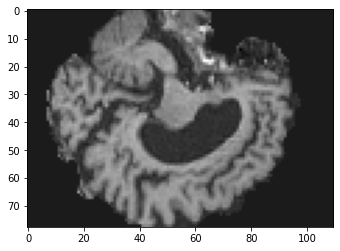

In [28]:
plt.imshow(img[:, :, 50], cmap='gray')
plt.show()

In [62]:
# load in sitk format
sitk_image_mci = sitk.ReadImage('/home/sysadm/Downloads/ADNI_ALL/ADNI_002_S_0729_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070217001935821_S16874_I40708.nii')
# transform into a numpy array
img_mci = sitk.GetArrayFromImage(sitk_image_mci)
# check the final shape
img_mci.shape

(166, 256, 256)

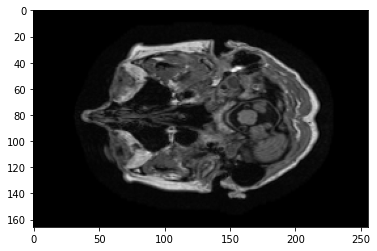

In [64]:
plt.imshow(img_mci[:, :,150], cmap='gray')
plt.show()

In [50]:
# load in sitk format
skull_image_mci = sitk.ReadImage('/home/sysadm/Music/MCI/ADNI_002_S_0729_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070217001935821_S16874_I40708.nii')
# transform into a numpy array
img_mci = sitk.GetArrayFromImage(skull_image_mci)
# check the final shape
img_mci.shape

(78, 110, 86)

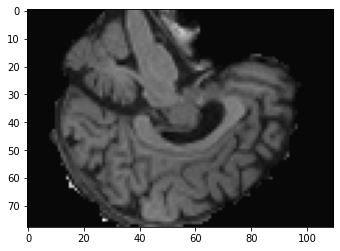

In [51]:
plt.imshow(img_mci[:, :,45], cmap='gray')
plt.show()